In [1]:
import GPy
import pickle
import numpy as np
from scipy.special import logsumexp

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# generate binary input vector
def simulate_single_input(time, Dv):
    inputs = np.zeros((time, Dv))
    if Dv > 0:

        number_of_non_zero_dimenions = np.random.choice(np.arange(3,8), 1)[0]

        non_zero_dimensions = np.random.choice(Dv - 1, number_of_non_zero_dimenions, replace=False)

        for k in non_zero_dimensions:
            start = np.random.choice(time - 1, 1)[0]
            end = start + 1 + np.random.choice(np.arange(40, 60),1)[0]
            end = min(end, time)
            inputs[start:end, k] = np.ones(end-start)

        # surgery is at the last axis
        start = np.random.randint(int(0.3 * time), int(0.6 * time))
        end = time
        inputs[start:end, -1] = np.ones(end-start)
    
    return inputs

In [3]:
def simulate_clv_with_inputs(A, g, Wv, f_cov, N, inputs, X_cov, beta):
    #  Wv: (Dx, Dv), W1 (Dx, Dv), W2 (1, Dx+1)
    # x_t + g_t + Wv v_t + (A+ A(v_t)) * p_t where A(v_t) = (W1 * vt) * W2
    latent_dim = A.shape[0]
    ndays, input_dim = inputs.shape
    x_mean = []
    y_count = []
    y_percentage = []

    mu = np.random.multivariate_normal(mean=np.zeros(latent_dim), cov=2 * np.eye(latent_dim))
    # simulate hidden alpha
    for t in range(ndays):
        xt = mu
        x_mean.append(xt)

        # increase dimension by 1
        xt1 = np.concatenate((xt, np.array([0])))
        pt = np.exp(xt1 - logsumexp(xt1))

        transition_noise = np.random.multivariate_normal(mean=np.zeros(latent_dim), cov=np.diag(f_cov))
        vt = inputs[t]

        mu = xt + g + Wv.dot(vt) + A.dot(pt) + transition_noise
    
    x_mean = np.array(x_mean)
    X = np.zeros_like(x_mean)
    for i in range(x_mean.shape[1]):
        X[:, i] = np.random.multivariate_normal(x_mean[:, i], X_cov)

    for xt in X:
        xt1 = np.concatenate((xt, np.array([0])))
        pt = np.exp(xt1 - logsumexp(xt1))
        pt = beta.dot(pt)

        # simulate total number of reads with over-dispersion
        logN = np.random.normal(loc=np.log(N), scale=0.5)
        Nt = np.random.poisson(np.exp(logN))

        yt_count = np.random.multinomial(Nt, pt).astype(float)
        yt_percentage = yt_count / np.sum(yt_count)

        y_count.append(yt_count)
        y_percentage.append(yt_percentage)

    return np.array(X), np.array(y_count), np.array(y_percentage)

In [4]:
Dx = 5
Dy = 2 * Dx
Dv = 0  # including surgery
n_train, n_test = 20, 20
time = 30
obs_percentage = 1.0

# interaction
A  = np.random.normal(loc=0, scale=0.3, size=(Dx, Dx))
for i in range(Dx):
    A[i, i] = -np.abs(A[i, i])
    for j in range(i + 1, Dx):
        A[i, j] = -np.sign(A[j, i]) * np.abs(A[i, j])

# inputs
Wv = np.random.normal(loc=0, scale=0.02, size=(Dx, Dv))
if Dv > 0:
    Wv[:, -1] = -np.abs(Wv[:, -1])
for i in range(Dv - 1):
    n_zero_items = int(Dx * 0.75)
    idxs = np.random.choice(np.arange(Dx), n_zero_items, replace=False)
    Wv[idxs, i] = np.zeros_like(idxs)

g = np.random.gamma(shape=1.1, scale=0.01, size=(Dx,))
f_cov = np.abs(np.random.normal(loc=0, scale=0.0, size=(Dx - 1,)))
N = 10000 # sequencing reads parameter

beta = np.zeros((Dy, Dx))
for i in range(Dx):
    beta[:, i] = np.ones(Dy) * 0.05 * Dy / (Dy - 2) ** 2
    beta[2 * i, i] = 0.6
    beta[2 * i + 1, i] = 0.3

k_var = 0.0
k_len = 1
kernel = GPy.kern.RBF(1, variance=k_var, lengthscale=k_len)

print("A\n" + "\n".join([" ".join(["{:>5.2f}".format(ele) for ele in row]) for row in A]))
print("g\n" + " ".join(["{:>5.3f}".format(ele) for ele in g]))
print("Wv\n" + "\n".join([" ".join(["{:>5.2f}".format(ele) for ele in row]) for row in Wv]))
print("f_cov\n" + " ".join(["{:>5.3f}".format(ele) for ele in f_cov]))

A_r = A[:-1] - A[-1:]
g_r = g[:-1] - g[-1:]
Wv_r = Wv[:-1] - Wv[-1:]

A
-0.03 -0.00 -0.41 -0.09  0.06
 0.43 -0.18 -0.13  0.18 -0.09
 0.05  0.29 -0.20  0.27 -0.15
 0.23 -0.47 -0.10 -0.07 -0.28
-0.58  0.33  0.23  0.13 -0.12
g
0.013 0.005 0.008 0.020 0.001
Wv





f_cov
0.000 0.000 0.000 0.000


In [5]:
overwrite_params = True
if overwrite_params:
    with open("data/clv_count_Dx_5_Dy_10_ntrain_20_obp_10_noinput.p", "rb") as f:
        d = pickle.load(f)
    A = d["A"]
    g = d["g"]
    Wv = d["Wv"]
    f_cov = d["f_cov"]
    N = d["N"]
    k_var = d["k_var"]
    k_len = d["k_len"]
    beta = d["beta"]
    
    A_r = A[:-1] - A[-1:]
    g_r = g[:-1] - g[-1:]
    Wv_r = Wv[:-1] - Wv[-1:]
    k_var = 0.05
    k_len = 2
    kernel = GPy.kern.RBF(1, variance=k_var, lengthscale=k_len)

In [6]:
# create data with missing observation
x_train = []
x_test = []
y_count_train = []
y_count_test = []
y_percentage_train = []
y_percentage_test = []
v_train = []
v_test = []

batch_inputs = [simulate_single_input(time, Dv) for _ in range(n_train + n_test)]
X_cov = kernel.K(np.arange(time)[:, np.newaxis])

for i in range(n_train + n_test):
    v = batch_inputs[i]  # (time, Dv)
    x, y_count, y_percentage = simulate_clv_with_inputs(A_r, g_r, Wv_r, f_cov, N, v, X_cov, beta)
    
    # make missing observations, the first day cannot be missing
    if int(time * obs_percentage) == time:
        obsed_days = np.arange(time)
    else:
        obsed_days = np.random.choice(np.arange(1, time), int(time * obs_percentage) - 1, replace=False)
        obsed_days = np.sort(np.concatenate(([0], obsed_days)))

    y_percentage = y_percentage[obsed_days]
    x = x[obsed_days]
    y_count = y_count[obsed_days]

    days = np.arange(time)[:, np.newaxis]
    y_count = np.concatenate([days[obsed_days], y_count], axis=-1)
    y_percentage = np.concatenate([days[obsed_days], y_percentage], axis=-1)
    v = np.concatenate([days, v], axis=-1)

    if i < n_train:
        x_train.append(x)
        y_count_train.append(y_count)
        y_percentage_train.append(y_percentage)
        v_train.append(v)
    else:
        x_test.append(x)
        y_count_test.append(y_count)
        y_percentage_test.append(y_percentage)
        v_test.append(v)

In [7]:
counts_train = []
for single_obs in y_count_train:
    single_counts = single_obs[:,1:].sum(axis=-1)
    counts_train.append(single_counts)
    
counts_test = []
for single_obs in y_count_test:
    single_counts = single_obs[:,1:].sum(axis=-1)
    counts_test.append(single_counts)

In [8]:
c_data = {}
c_data["Xtrain"] = x_train
c_data["Xtest"] = x_test
c_data["Ytrain"] = y_count_train
c_data["Ytest"] = y_count_test
c_data["Vtrain"] = v_train
c_data["Vtest"] = v_test
c_data["counts_train"] = counts_train
c_data["counts_test"] = counts_test

c_data["A"] = A
c_data["g"] = g
c_data["Wv"] = Wv
c_data["f_cov"] = f_cov
c_data["N"] = N
c_data["k_var"] = k_var
c_data["k_len"] = k_len
c_data["beta"] = beta

with open("data/clv_count_Dx_{}_Dy_{}_ntrain_{}_obp_{:02d}_noinput.p".format(Dx, Dy, n_train, int(obs_percentage * 10)), "wb") as f:
    pickle.dump(c_data, f)

# visualize the data

In [9]:
import sys
sys.path.append("../..")

In [10]:
from src.utils.data_interpolation import interpolate_data

In [11]:
hidden_train, hidden_test, obs_train, obs_test, input_train, input_test = x_train, x_test, y_percentage_train, y_percentage_test, v_train, v_test

In [12]:
extra_inputs_train = [None for _ in range(len(obs_train))]
extra_inputs_test = [None for _ in range(len(obs_test))]

In [13]:
hidden_train, hidden_test, obs_train, obs_test, input_train, input_test, _mask_train, _mask_test, time_interval_train, time_interval_test, extra_inputs_train, extra_input_test = \
    interpolate_data(hidden_train, hidden_test, obs_train, obs_test, input_train, input_test,
                     extra_inputs_train, extra_inputs_test, interpolation_type=None)


masks = _mask_train + _mask_test
obs = obs_train + obs_test
inputs = input_train + input_test

In [14]:
# count data
c_hidden_train, c_hidden_test, c_obs_train, c_obs_test, c_input_train, c_input_test, c_extra_inputs_train, c_extra_inputs_test = x_train, x_test, y_count_train, y_count_test, v_train, v_test, counts_train, counts_test

In [15]:
c_hidden_train, c_hidden_test, c_obs_train, c_obs_test, c_input_train, c_input_test, c_mask_train, c_mask_test, time_interval_train, time_interval_test, c_extra_inputs_train, c_extra_input_test = \
                interpolate_data(c_hidden_train, c_hidden_test, c_obs_train, c_obs_test, c_input_train, c_input_test,
                                 c_extra_inputs_train, c_extra_inputs_test)


c_masks = c_mask_train + c_mask_test
c_obs = c_obs_train + c_obs_test
c_inputs = c_input_train + c_input_test

In [16]:
def bar_plot(ax, obs, mask, to_normalize=True):
    if to_normalize:
            obs = obs / np.sum(obs, axis=-1, keepdims=True)

    time, Dy = obs.shape

    # make missing obs = 0
    masked_obs = np.zeros_like(obs)
    masked_obs[mask] = obs[mask]
    
    ax.set_xlabel("Time")
    bottom = np.zeros(time)
    for j in range(Dy):
        ax.bar(np.arange(time), masked_obs[:, j], bottom=bottom, edgecolor='white')
        bottom += masked_obs[:, j]

    ax.set_xticks(np.arange(time))
    sns.despine()
    

def input_plot(ax, inputs):
    time, Dv = inputs.shape
    
    for j in range(Dv):
        has_inputs = inputs[:,j]== 1
        idx = np.arange(time)[has_inputs]
        ax.bar(idx, [1 for _ in idx], bottom=[j for _ in idx], color='blue')
    
    ax.set_xticks(np.arange(time))
    ax.set_yticks(np.arange(Dv))
    sns.despine()

In [17]:
def plot_inputs_and_obs(inputs, masks, i, to_normalize=True):
    plt.figure(figsize=(15,10))

    ax1= plt.subplot(2,1,1)
    input_plot(ax1, inputs[i])
    ax1.grid()

    ax2 = plt.subplot(2,1,2, sharex = ax1)
    bar_plot(ax2, obs[i], masks[i], to_normalize=to_normalize)
    ax2.grid()

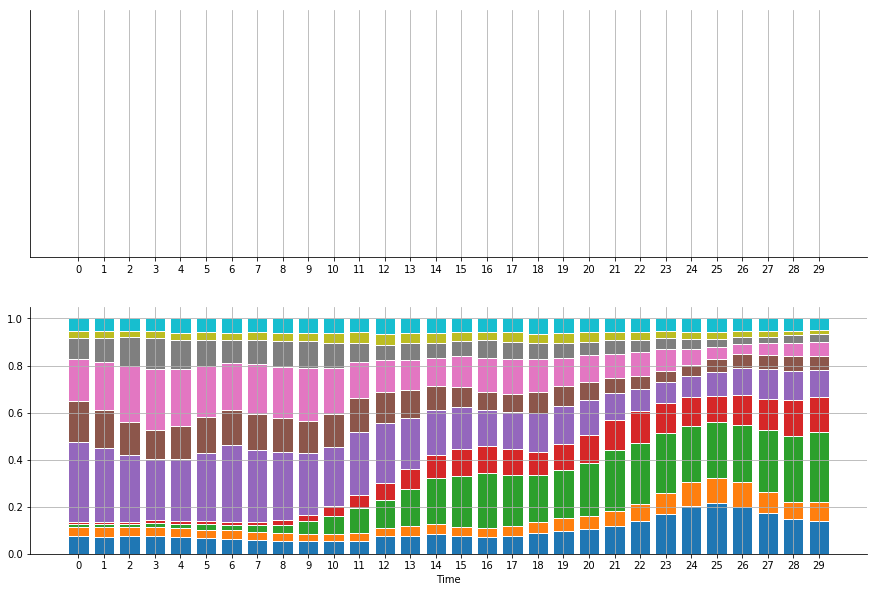

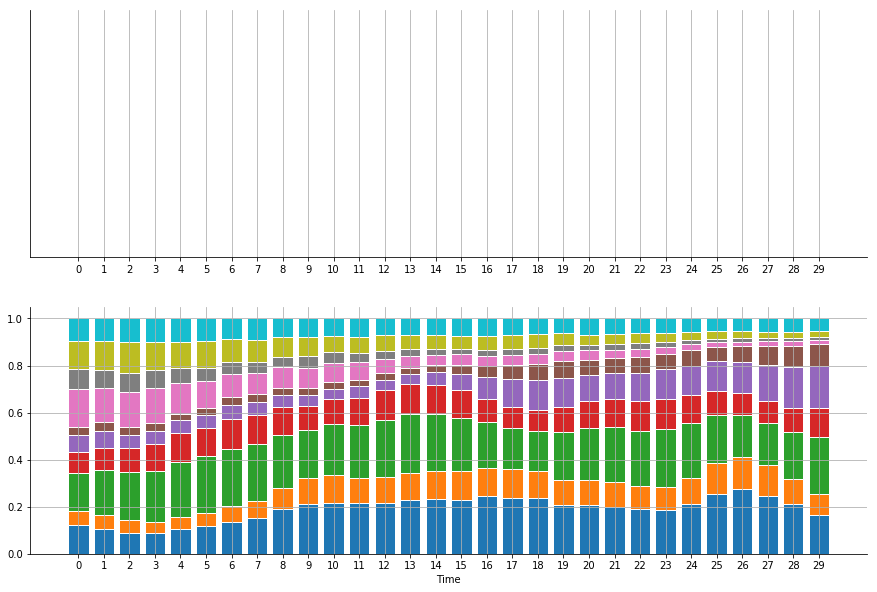

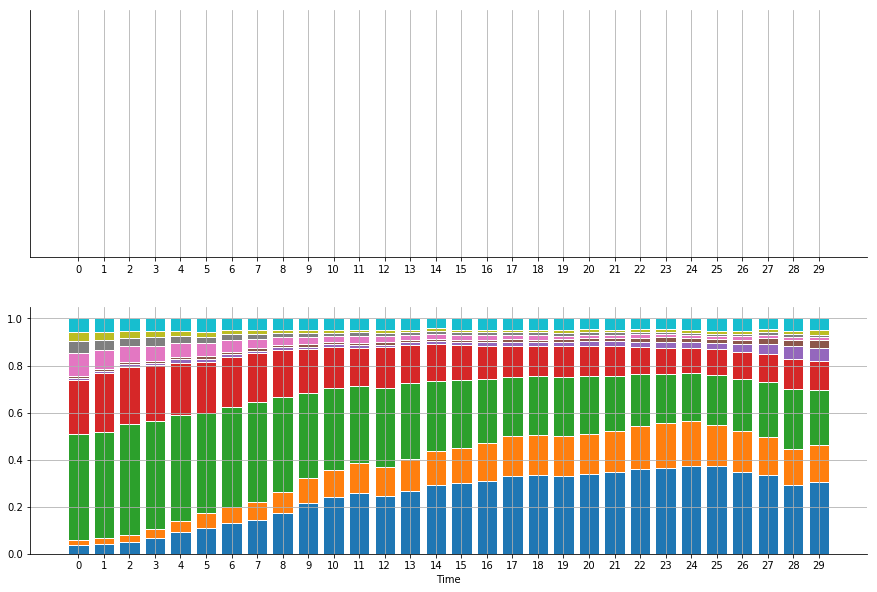

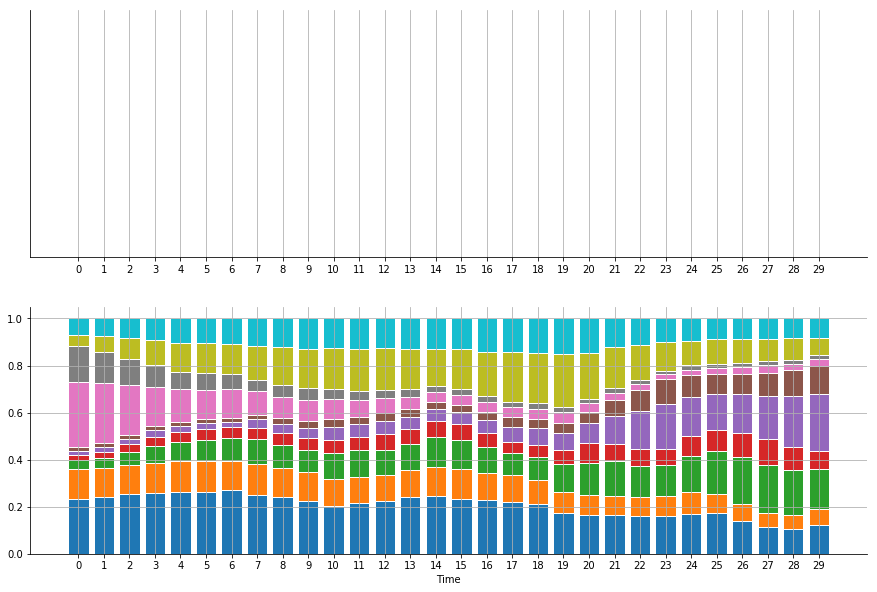

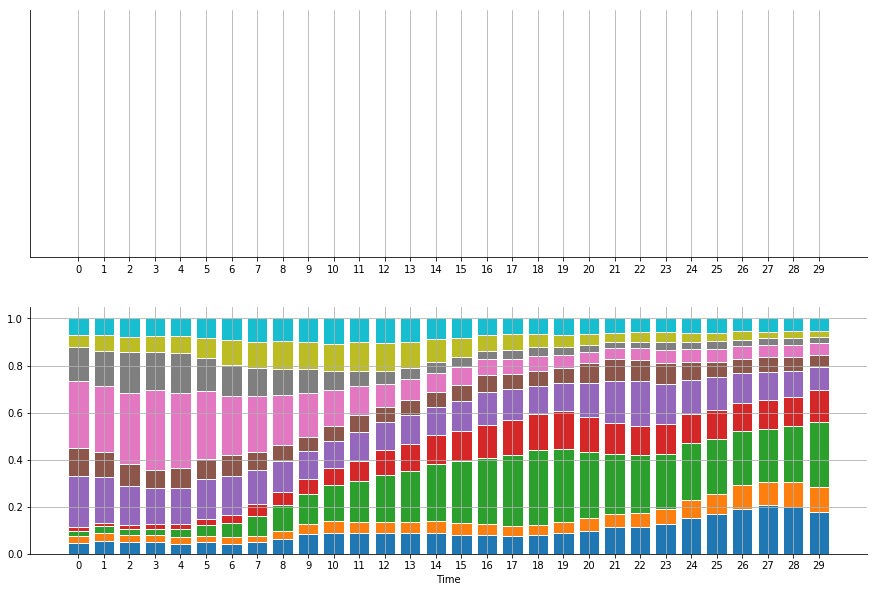

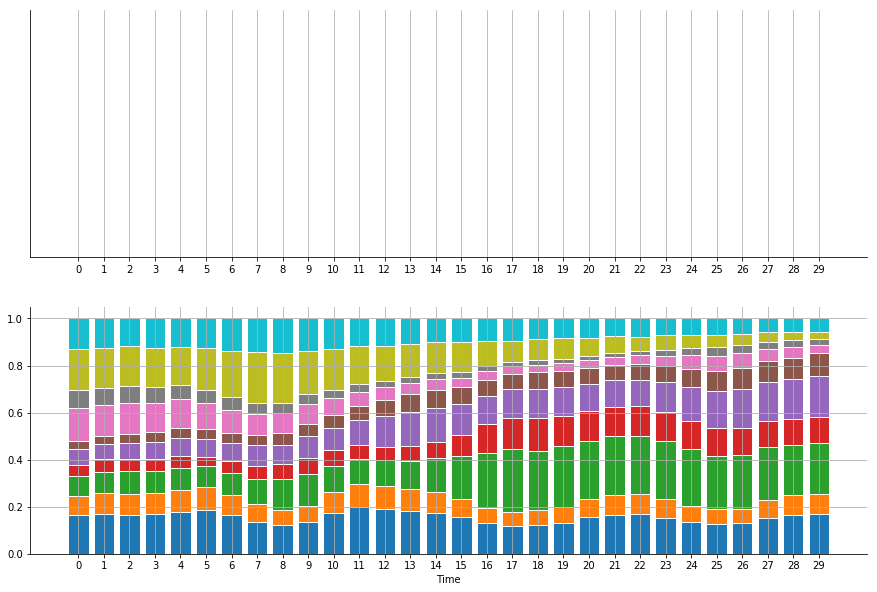

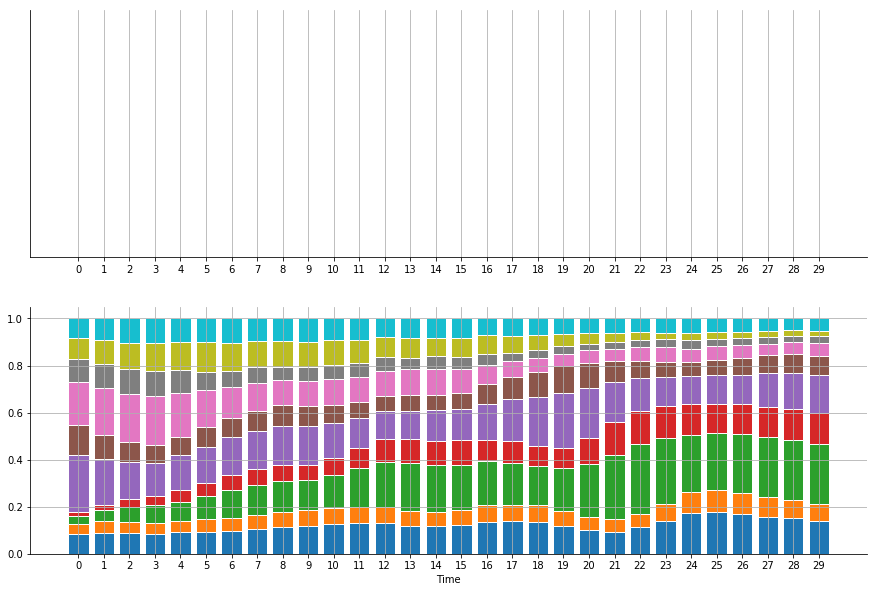

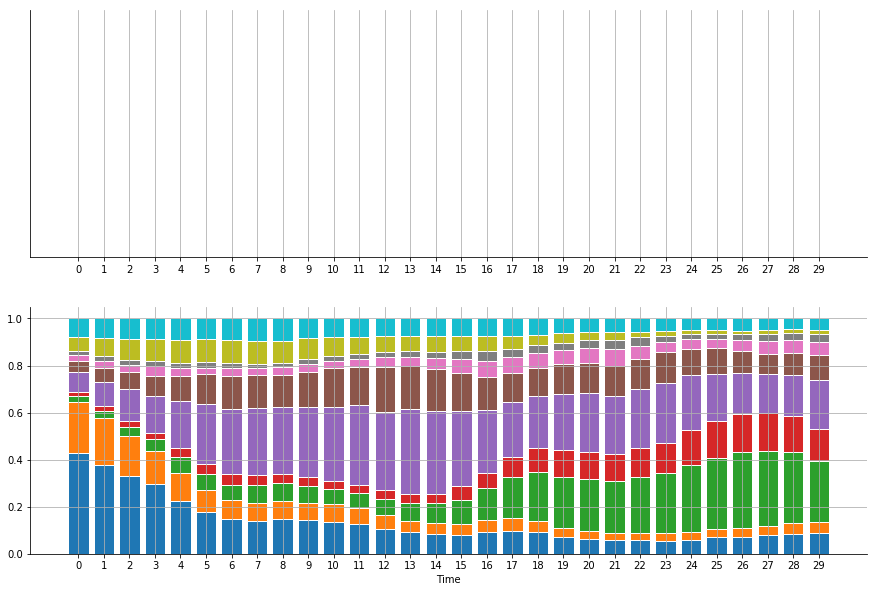

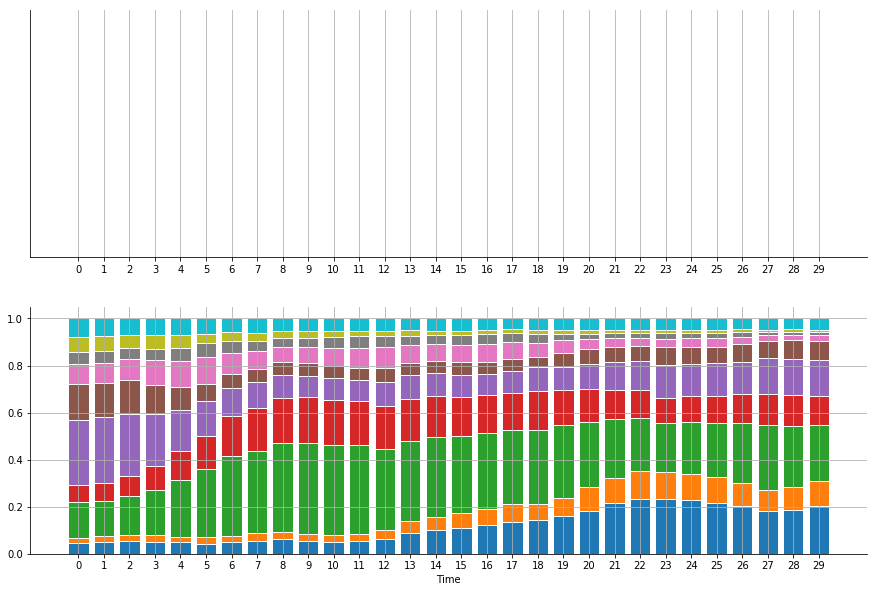

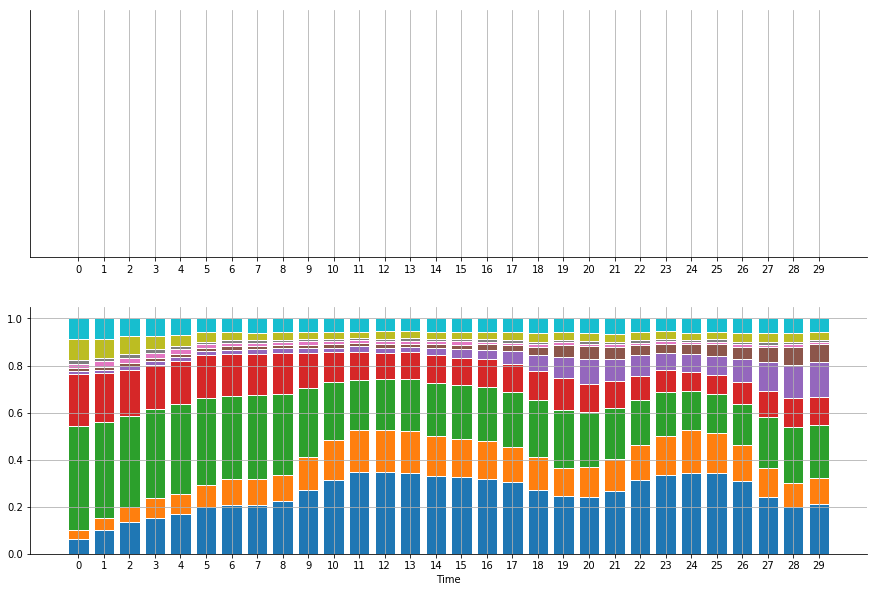

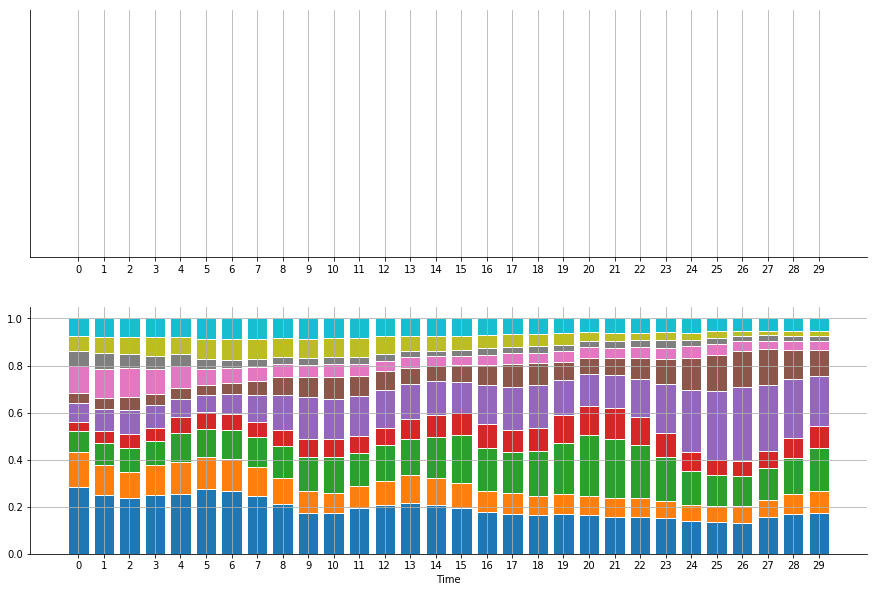

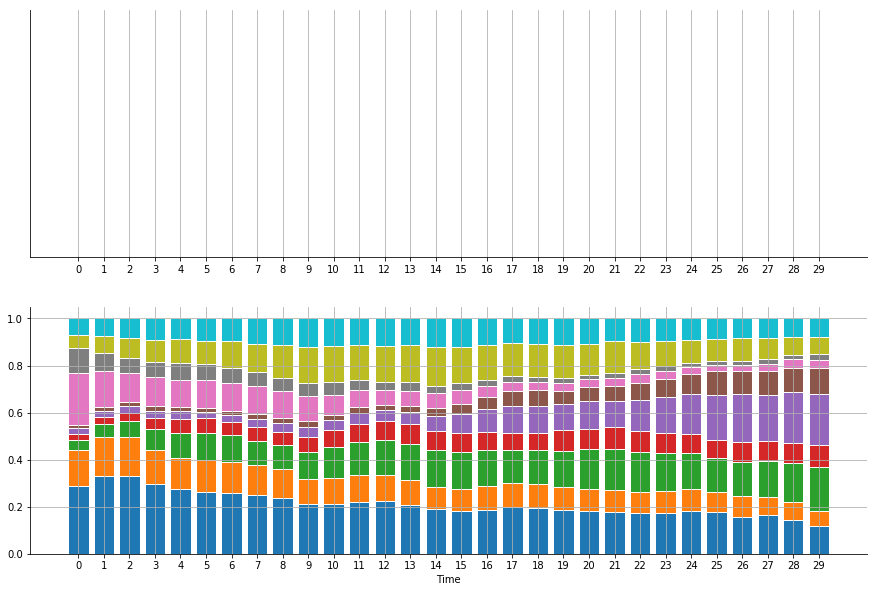

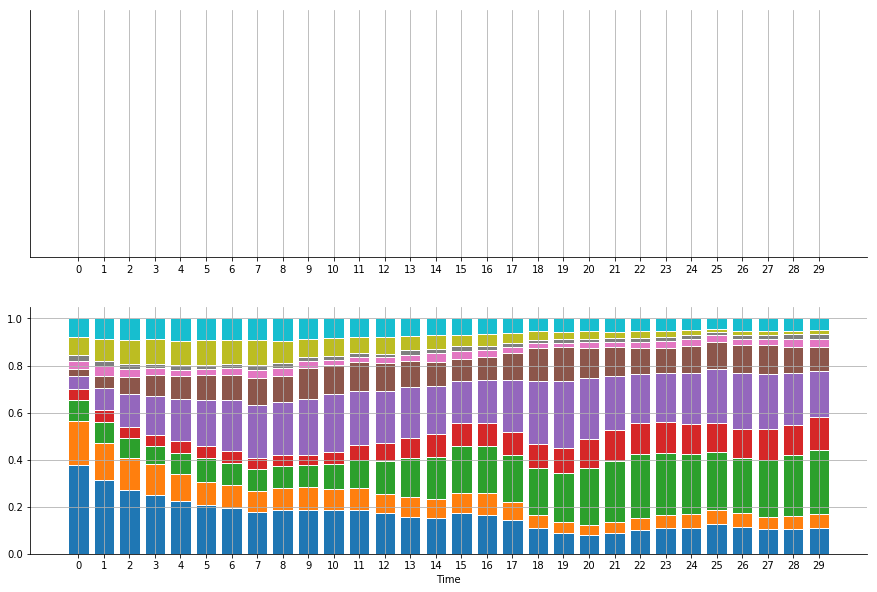

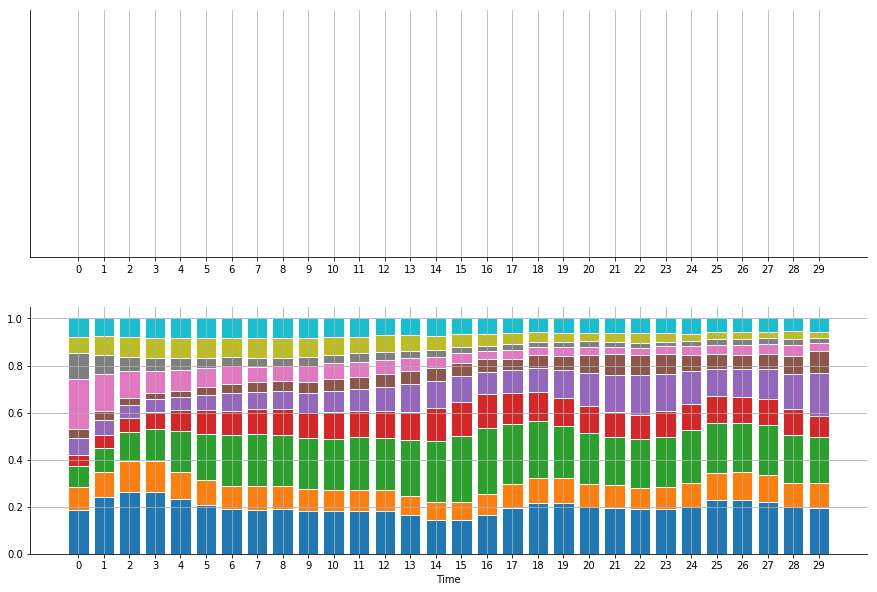

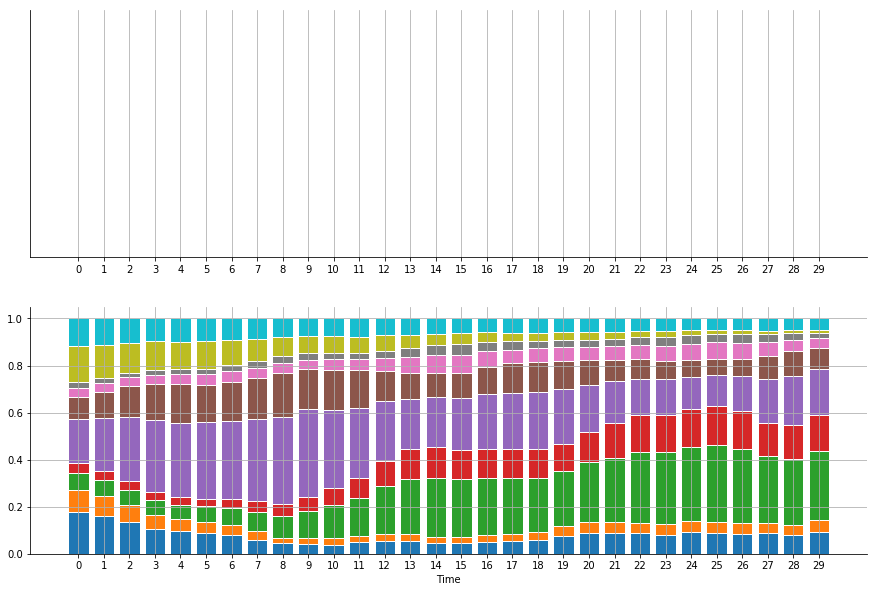

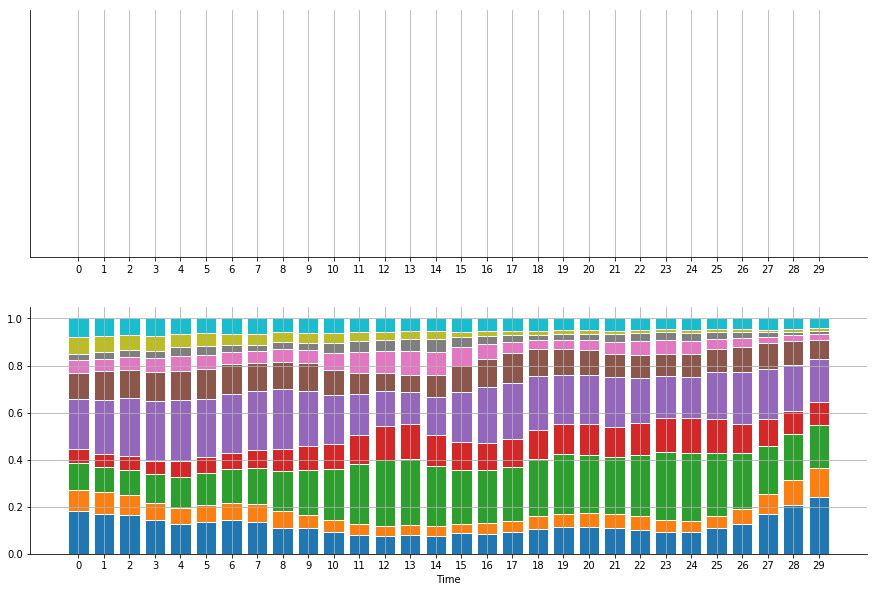

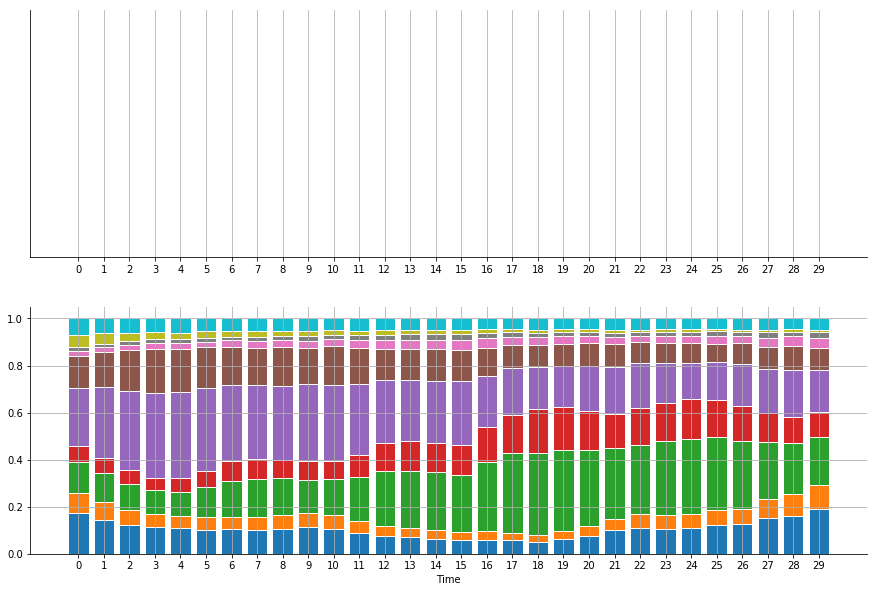

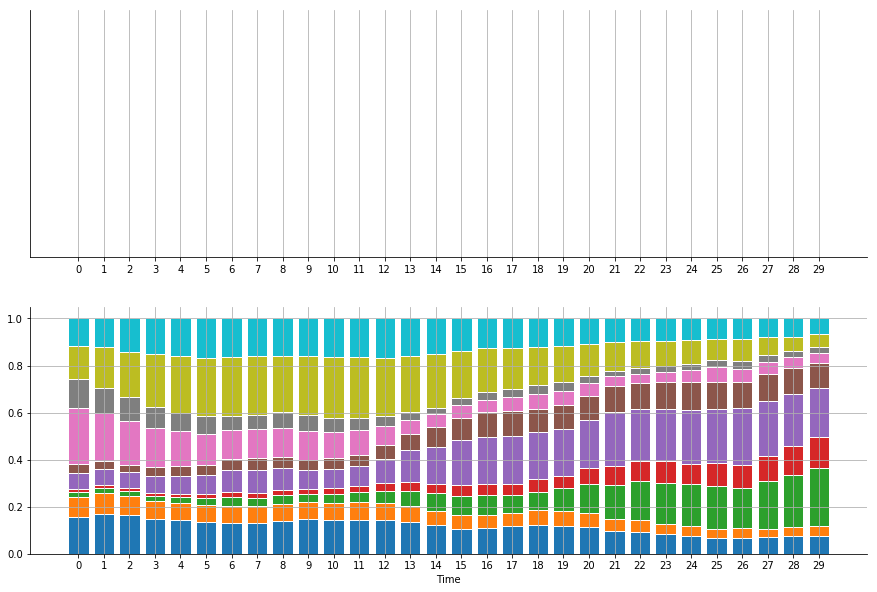

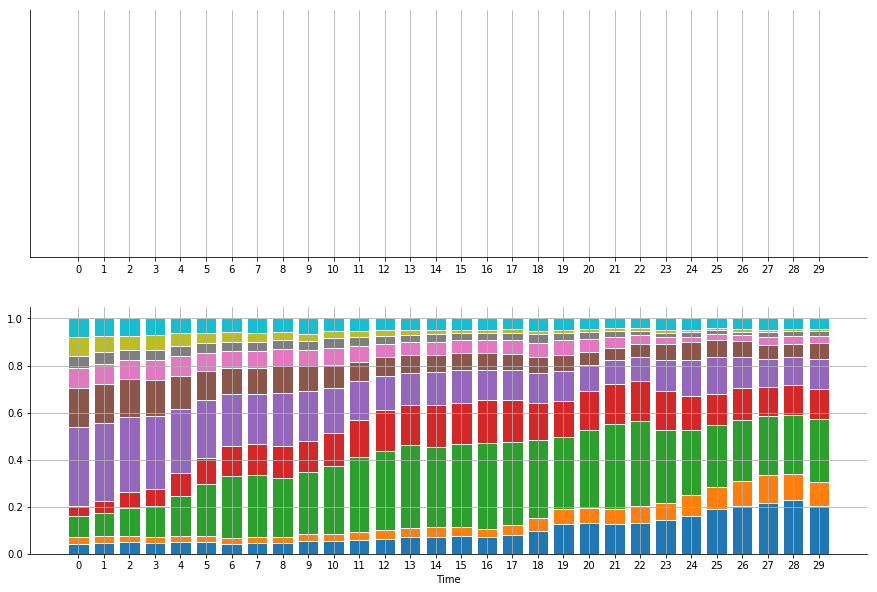

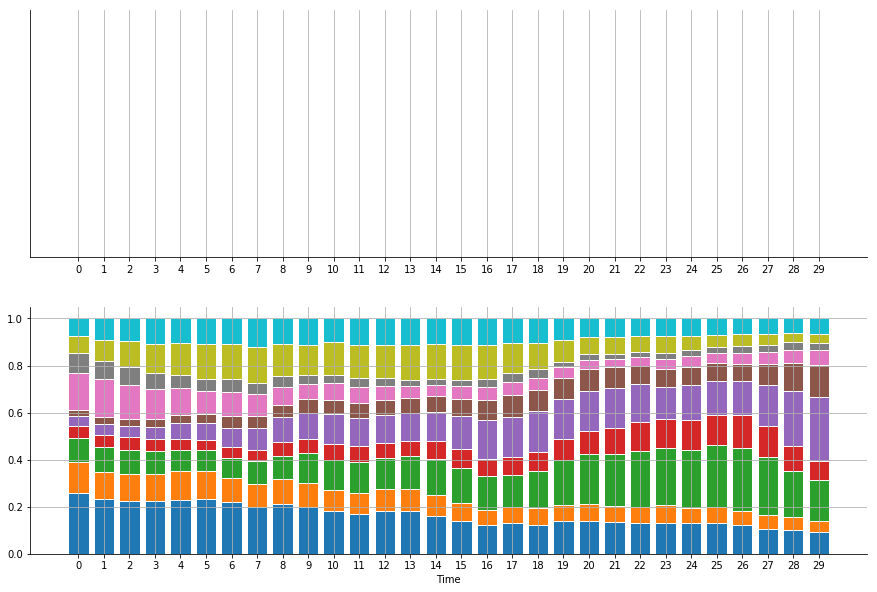

In [18]:
for i in range(20):
    plot_inputs_and_obs(inputs, masks, i)

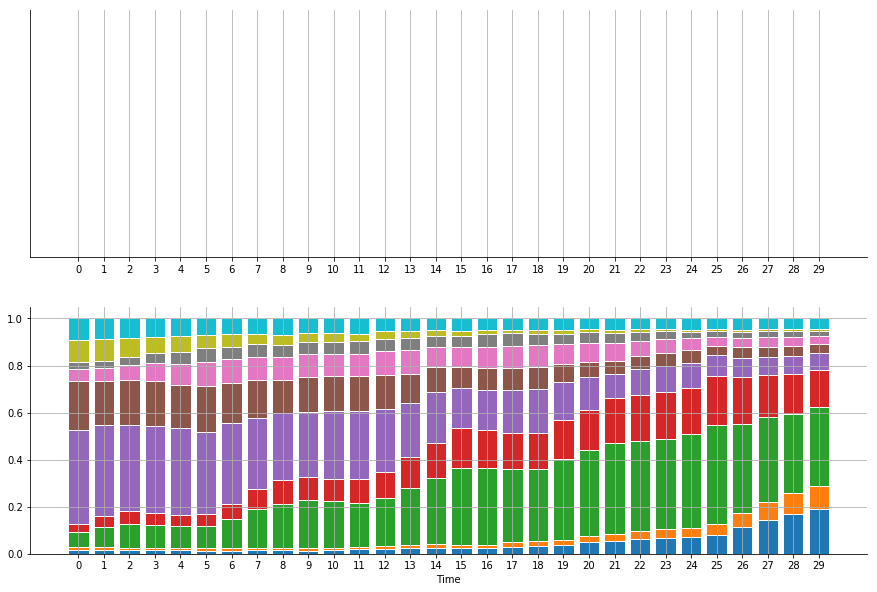

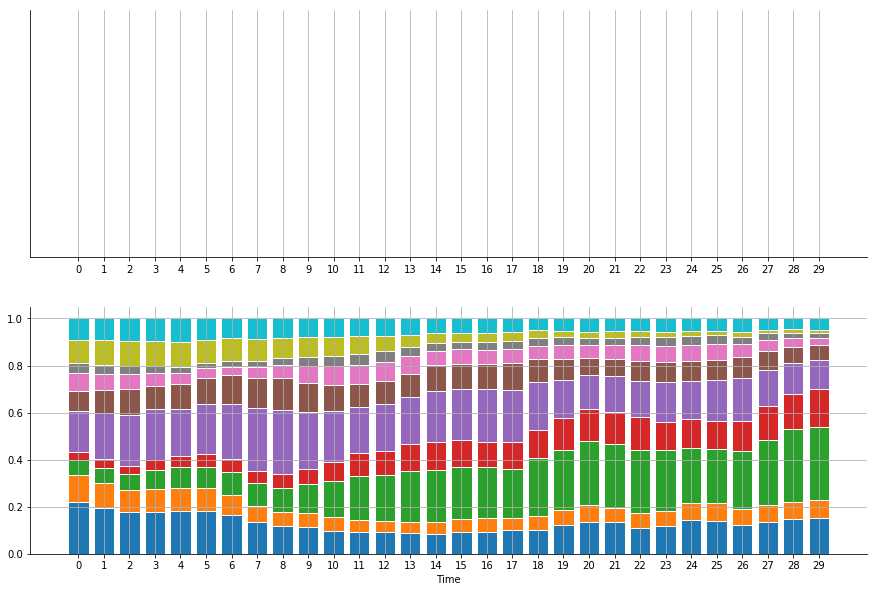

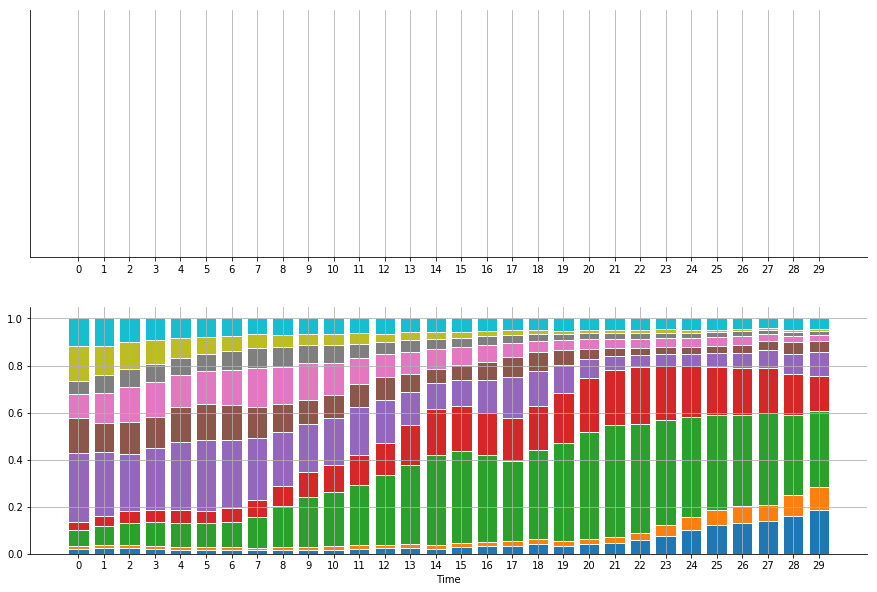

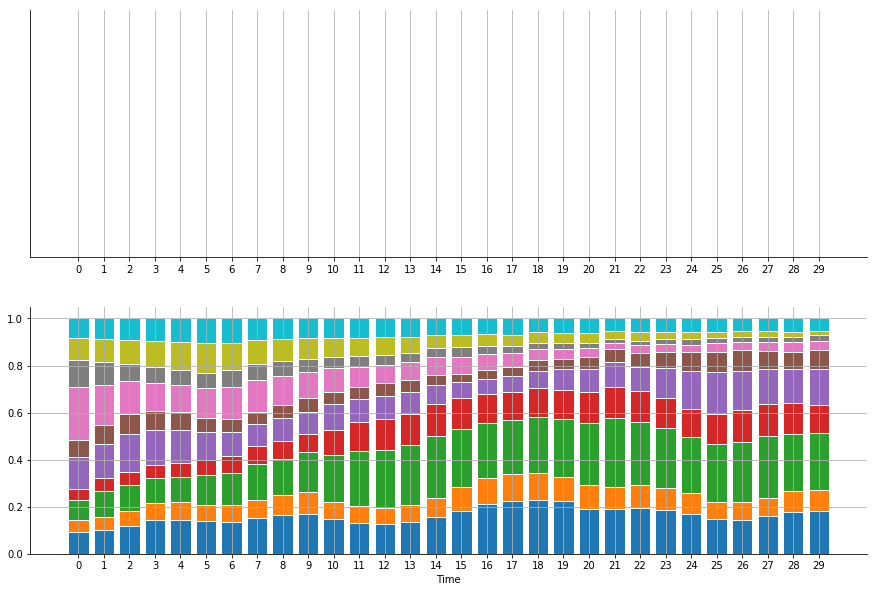

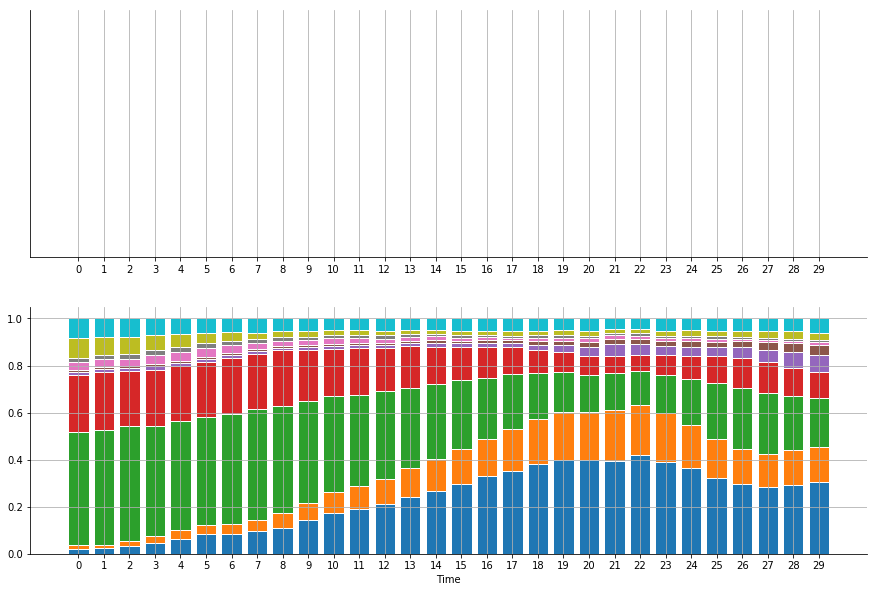

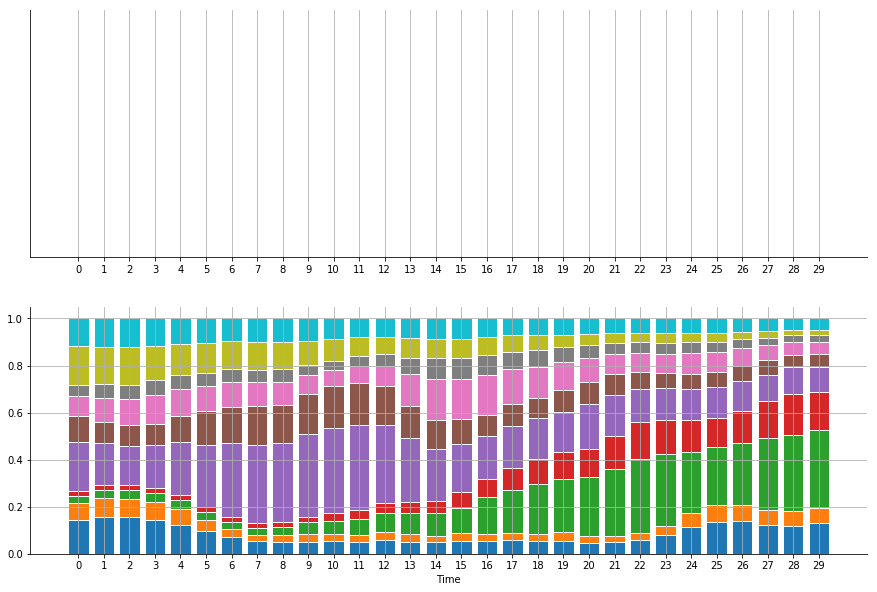

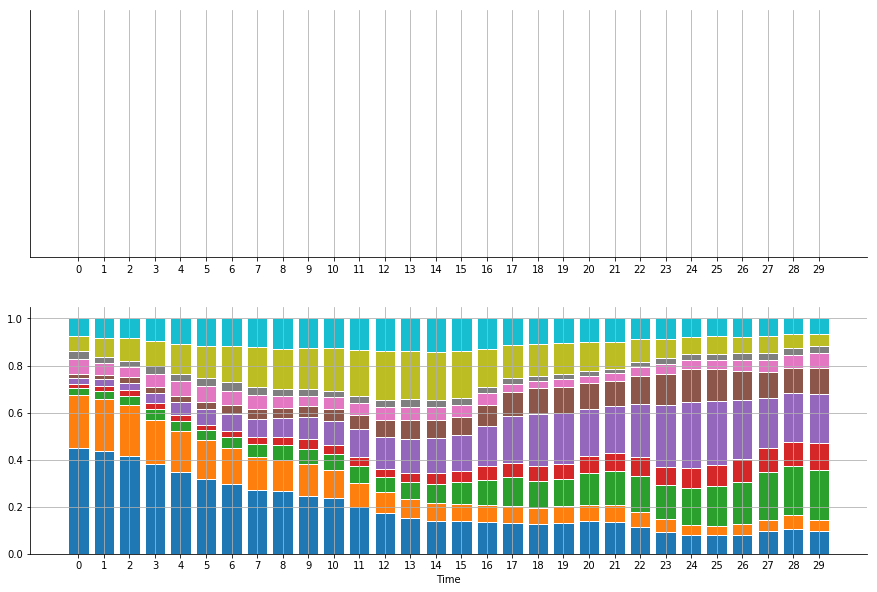

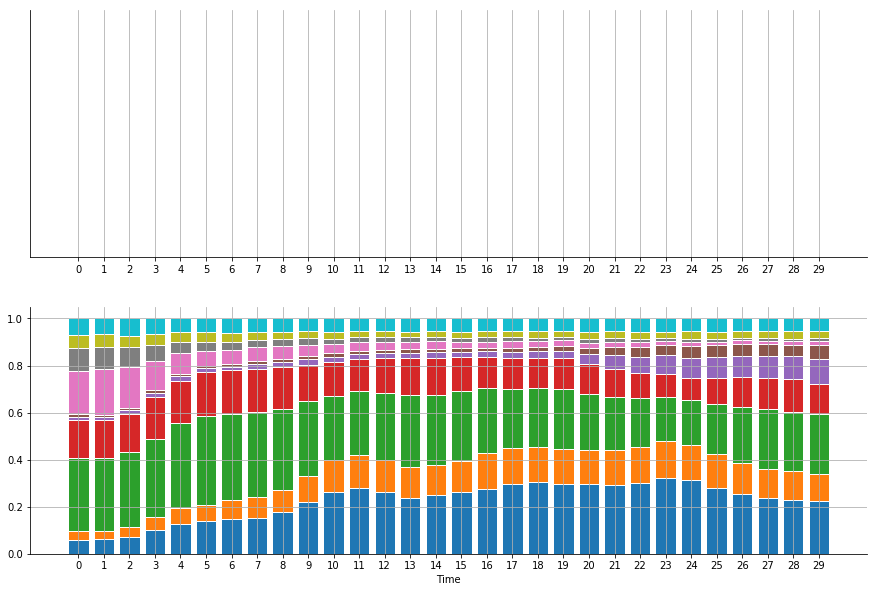

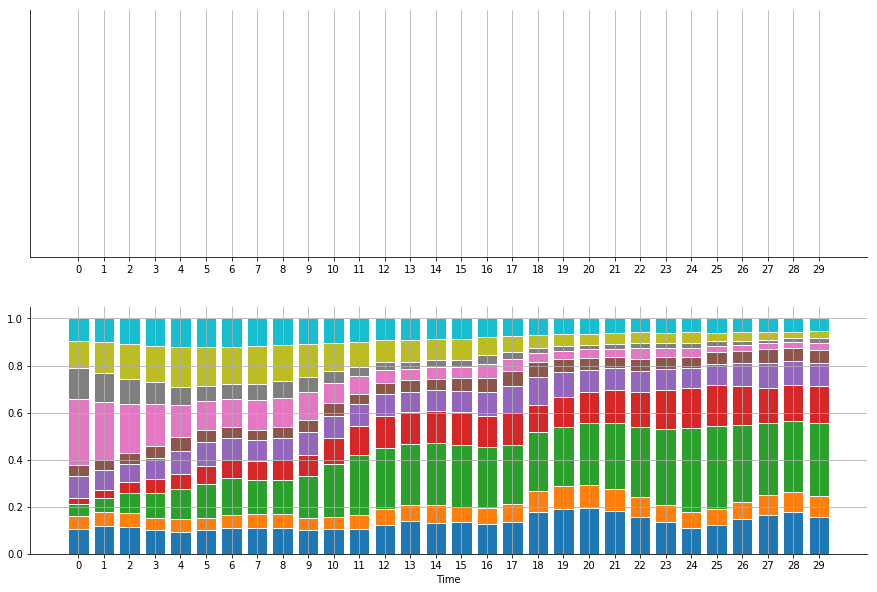

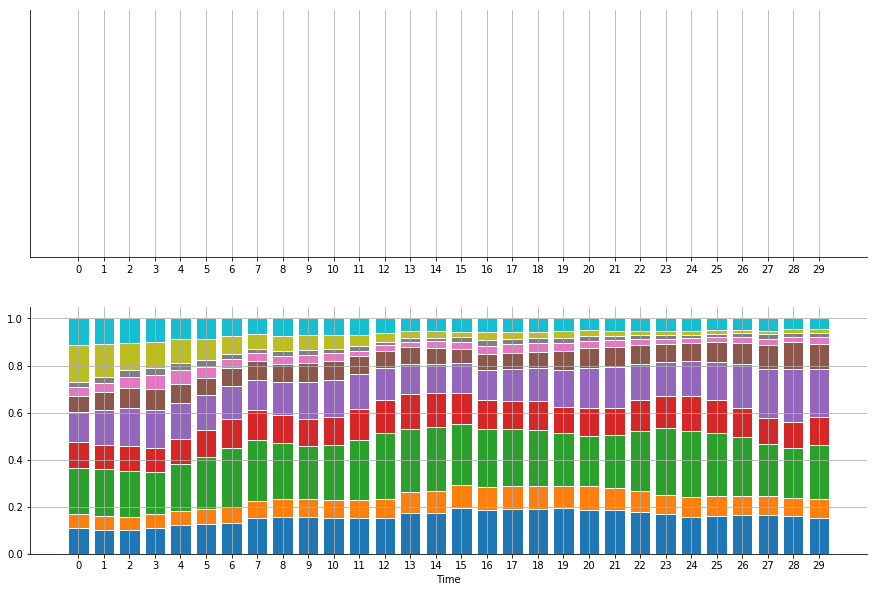

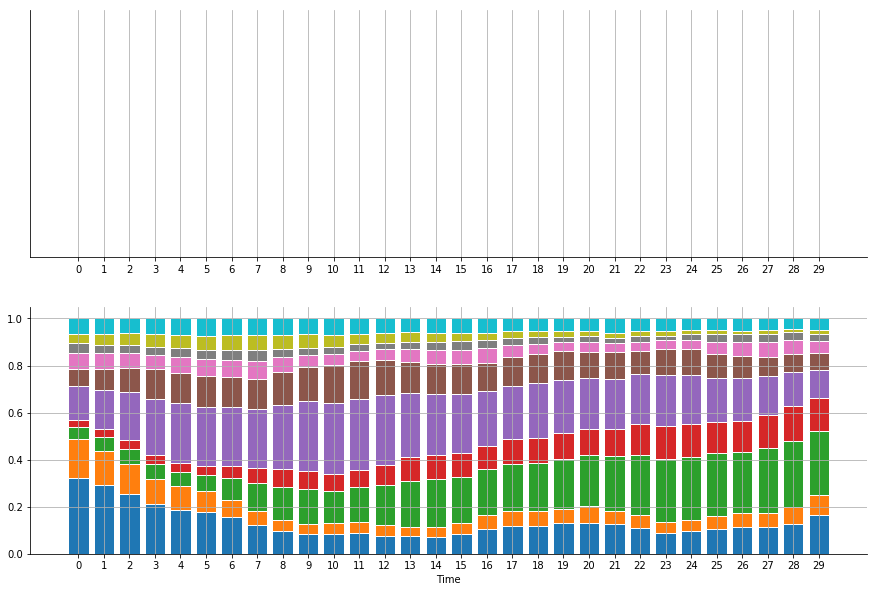

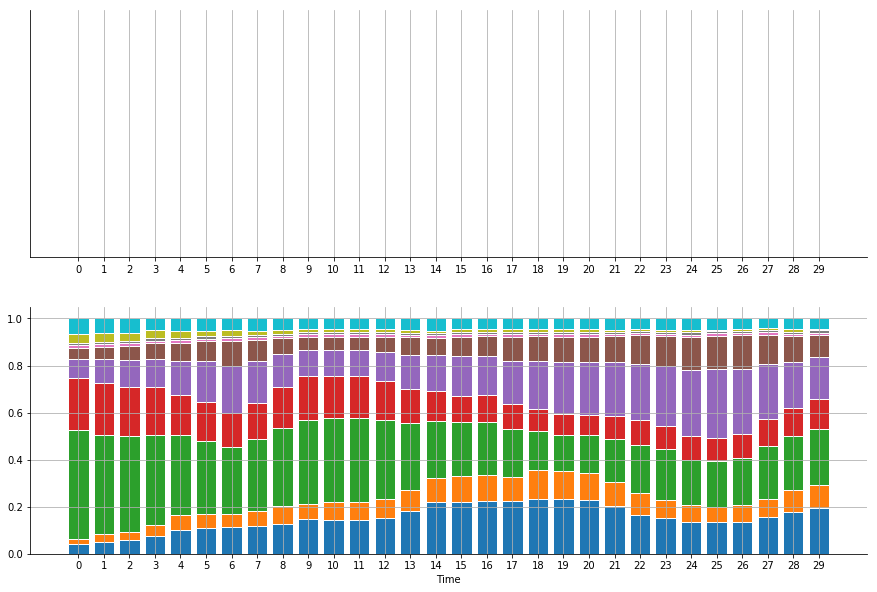

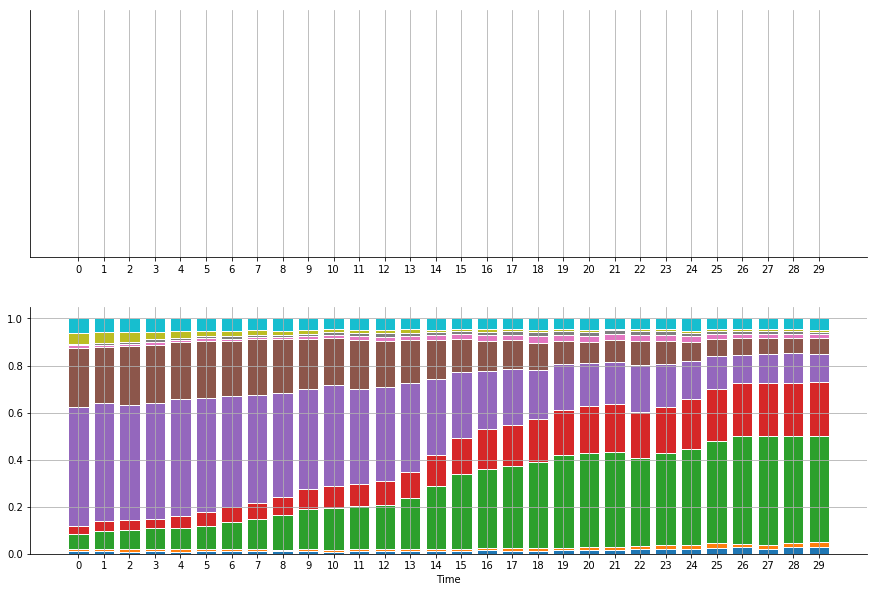

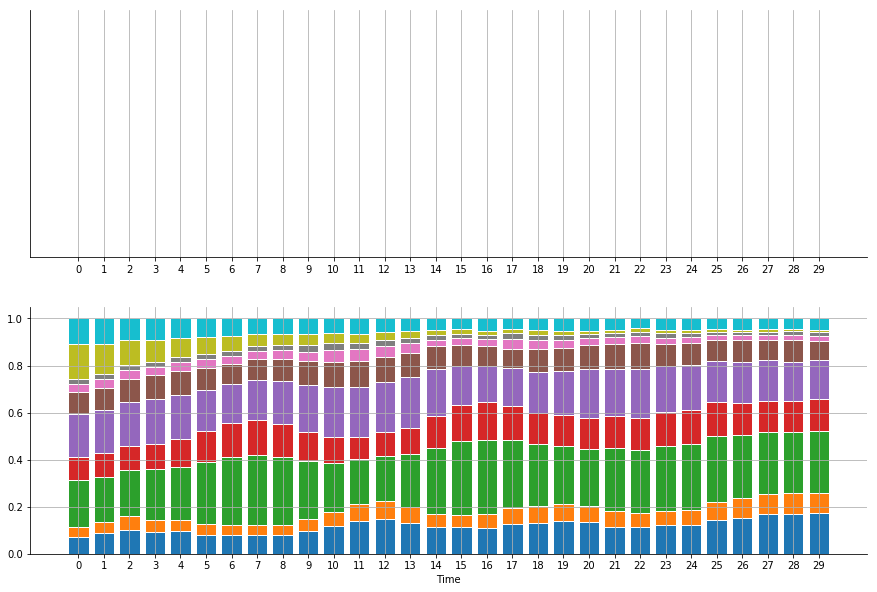

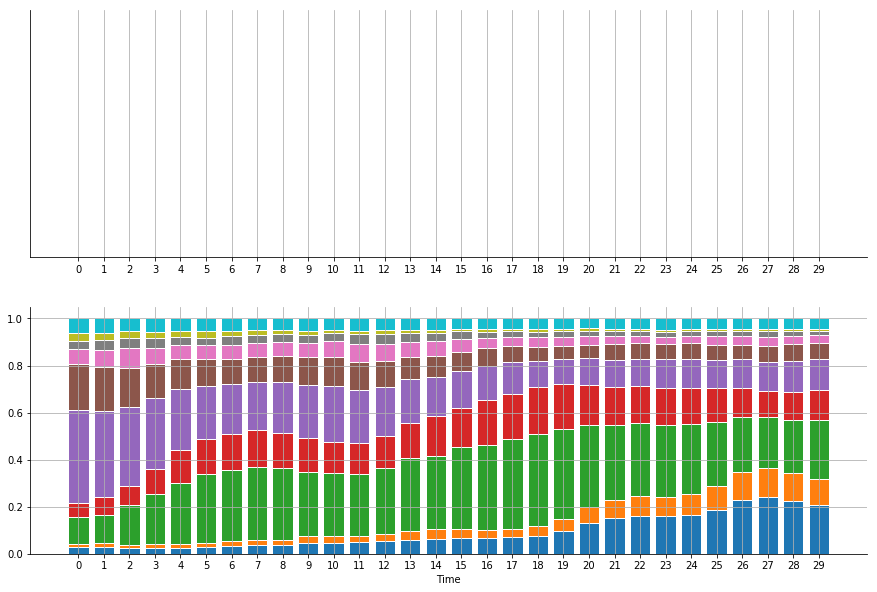

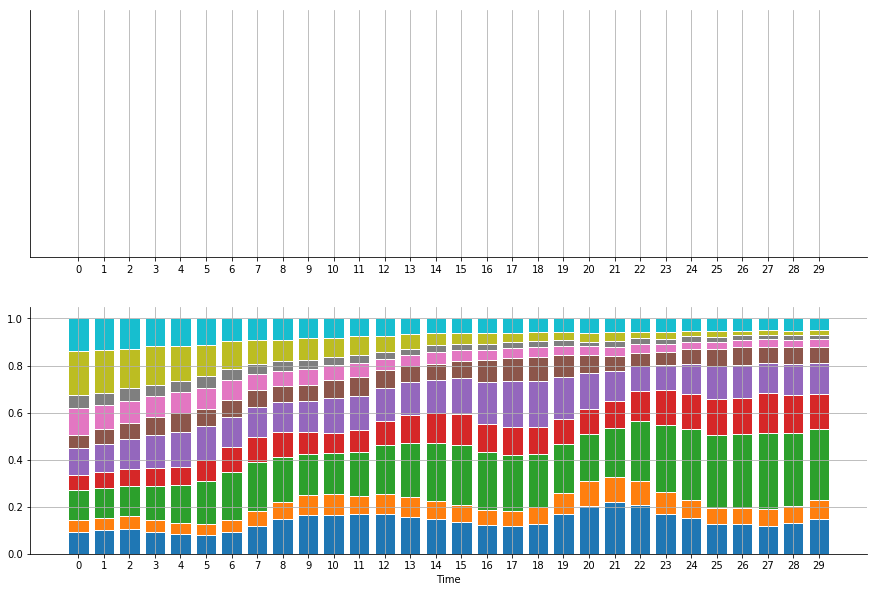

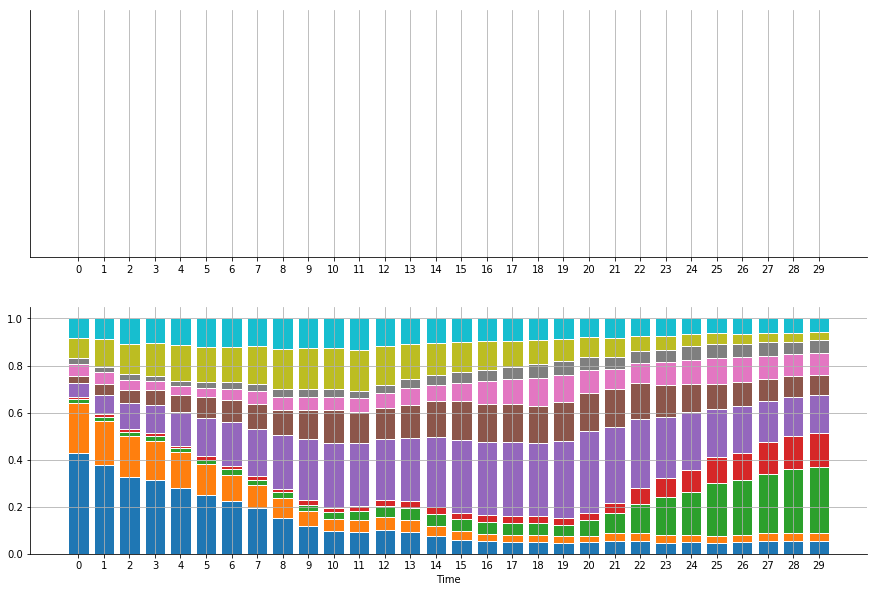

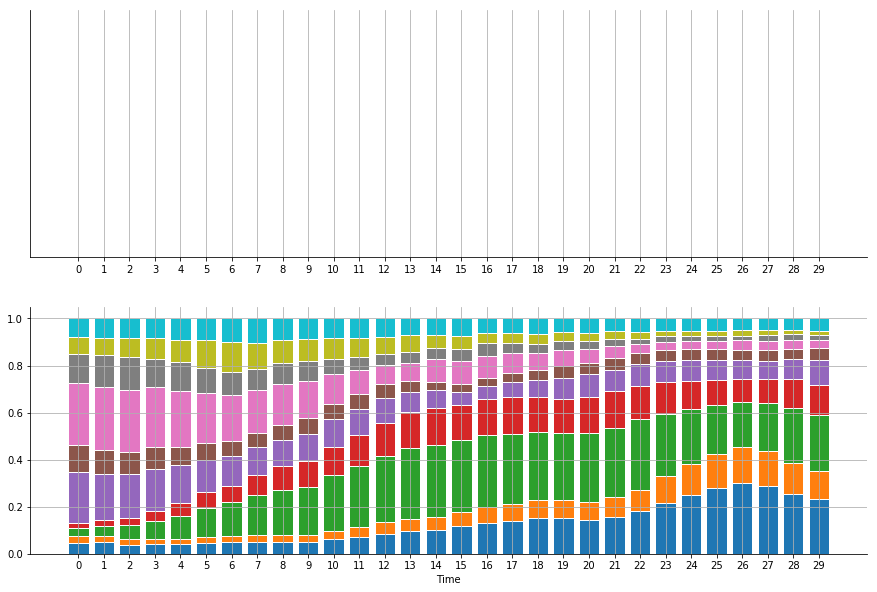

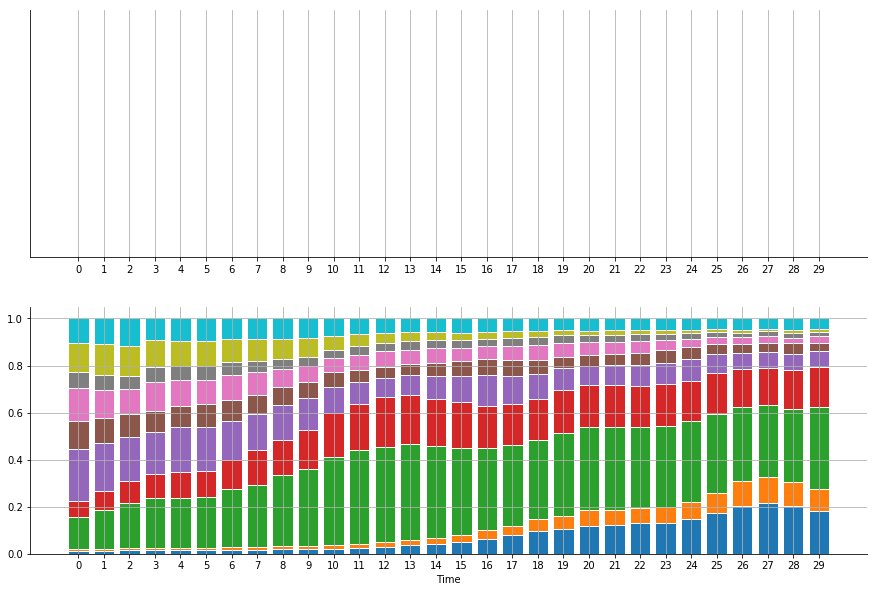

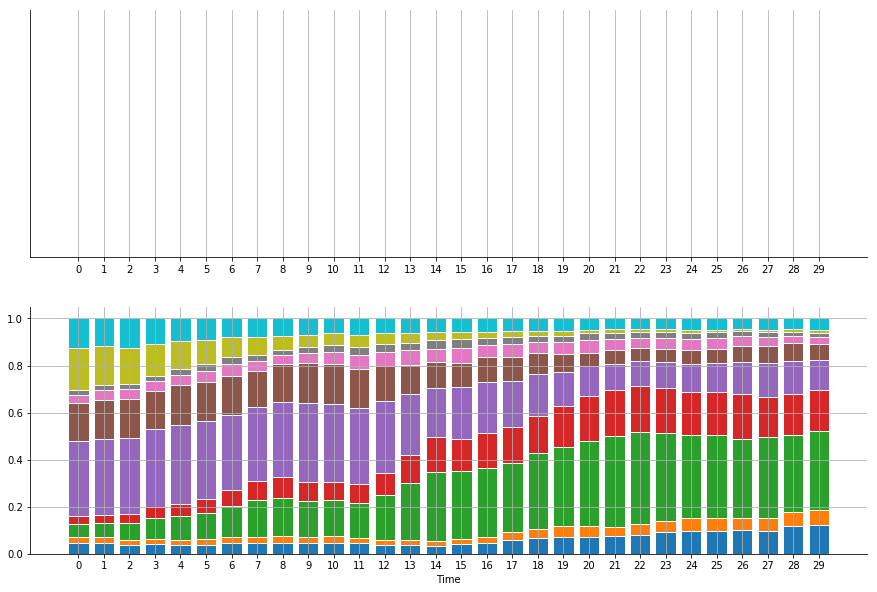

In [19]:
for i in range(20, 40):
    plot_inputs_and_obs(c_inputs, c_masks, i, to_normalize=True)